# Negative Initial Time example
***
In this Example we use a simple `HISRD` model with an infection event occuring at `t=0` to show the proper method to simulate a model with an initial time < 0.
***
## Setup the Environment
***

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../..')))

In [2]:
import numpy as np

In [3]:
import gillespy2

***
## Build the Model
***

In [4]:
def build_hisrd(end_time=100, parameter_values=None):
    # Initialize model                                                                                                                                                                                                      
    model = gillespy2.Model(name="HISRD")

    # Define Variables (GillesPy2.Species)                                                                                                                                                                                             
    healthy = gillespy2.Species(name='healthy', initial_value=10000)
    infected = gillespy2.Species(name='infected', initial_value=0)
    symptomatic = gillespy2.Species(name='symptomatic', initial_value=0)
    dead = gillespy2.Species(name='dead', initial_value=0)
    recovered = gillespy2.Species(name='recovered', initial_value=0)
    
    # Add Variables to Model
    model.add_species([healthy, infected, symptomatic, dead, recovered])

    # Define Parameters                                                                                                                                                                                                                 
    infect = gillespy2.Parameter(name='infect', expression=np.exp(np.log(0.0001)))
    progress = gillespy2.Parameter(name='progress', expression=np.exp(np.log(0.071)))
    recovery = gillespy2.Parameter(name='recovery', expression=np.exp(np.log(0.8)))
    death = gillespy2.Parameter(name='death', expression=np.exp(np.log(0.2)))
    infect_start = gillespy2.Parameter('infect_start', expression=0)
    
    # Add Parameters to Model
    model.add_parameter([infect, progress, recovery, death, infect_start])

    # Define Reactions
    r1 = gillespy2.Reaction(
        name='r1', reactants={'healthy': 1, 'infected': 1 }, products={'infected': 2}, rate='infect'
    )
    r2 = gillespy2.Reaction(
        name='r2', reactants={'healthy': 1, 'symptomatic': 1},
        products={'infected': 1, 'symptomatic': 1}, rate='infect'
    )
    r3 = gillespy2.Reaction(name='r3', reactants={'infected': 1}, products={'symptomatic': 1}, rate='progress')
    r4 = gillespy2.Reaction(name='r4', reactants={'symptomatic': 1}, products={'dead': 1}, rate='death')
    r5 = gillespy2.Reaction(name='r5', reactants={'symptomatic': 1}, products={'recovered': 1}, rate='recovery')
    
    # Add Reactions to Model
    model.add_reaction([r1, r2, r3, r4, r5])
    
    # Define Event Triggers
    trigger = gillespy2.EventTrigger(expression=f"t > infect_start")
    
    # Define Event Assignments
    infection_intro = gillespy2.EventAssignment(variable="infected", expression="1")
    
    # Define Events
    e1 = gillespy2.Event(name="Infection_Introduction", trigger=trigger, assignments=[infection_intro])
    
    # Add Events to Model
    model.add_event(e1)

    # Define Timespan
    tspan = gillespy2.TimeSpan.arange(t=end_time, increment=1)
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

### Instantiate the Model
Here, we build a model that will simulate the disease progression without data prior to the infection.  We use an event to introduce the infection.

In [5]:
model = build_hisrd()

In [6]:
p_model = build_hisrd(end_time=150)

***
## Run the Simulations
***
#### Simulate from Infection Introduction

In [7]:
results = model.run()

#### Simulate Infection with past population data
To model population data from prior to the infection we need to modify the infect event trigger by the ent time of the add period.  We do this using the variable solver to modify the infect_start parameter.

In [8]:
p_results = p_model.run(variables={'infect_start': 50})

***
## Process Results
***
To visualize the results with the infection event at `t=0` we must shift the time sub array in the results by the added simulation time.

In [9]:
p_results[0]['time'] = p_results[0]['time'] - 50

***
## Visualizations
***

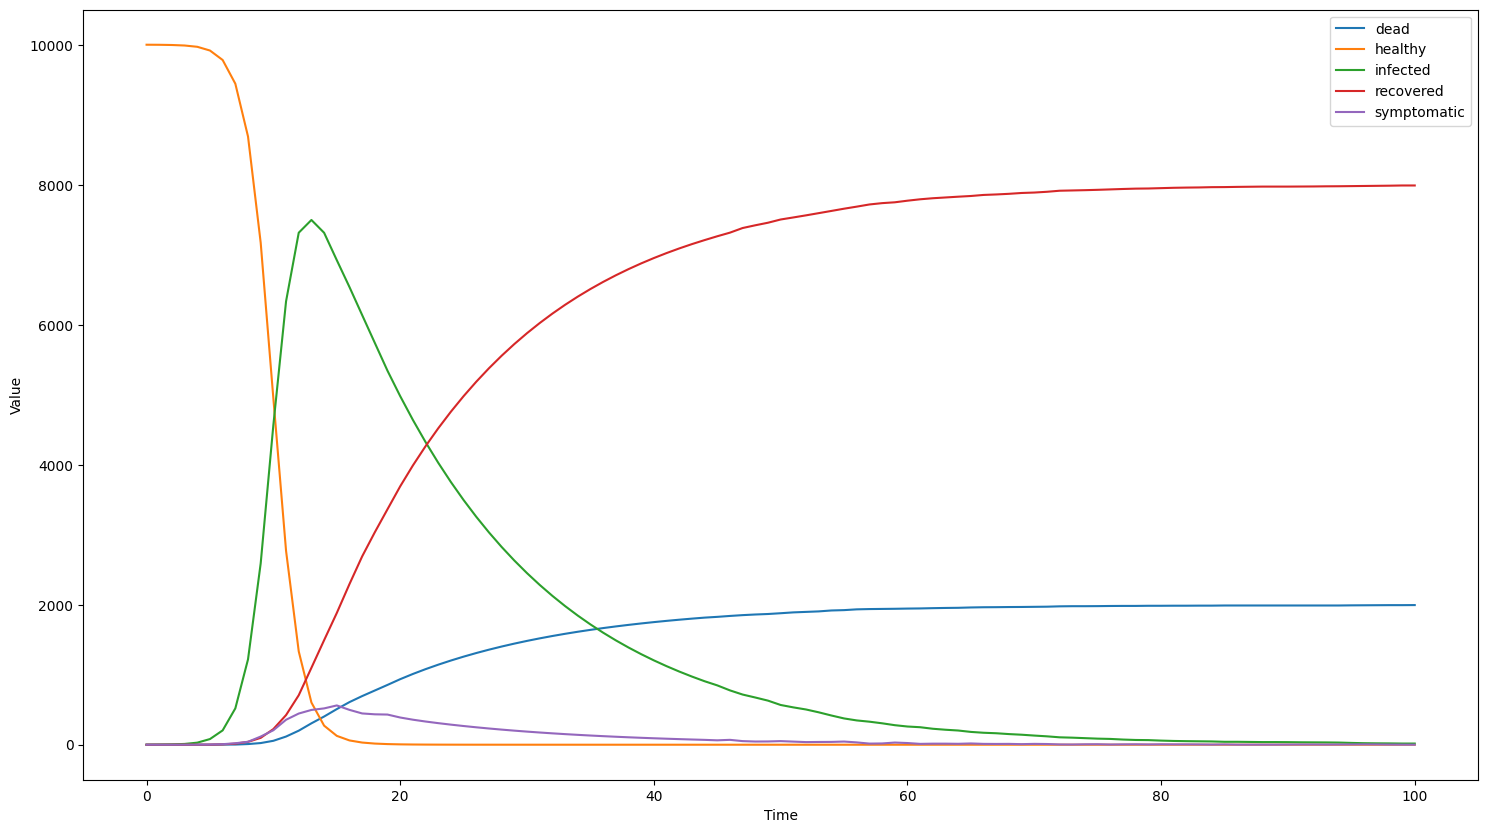

In [10]:
results.plot()

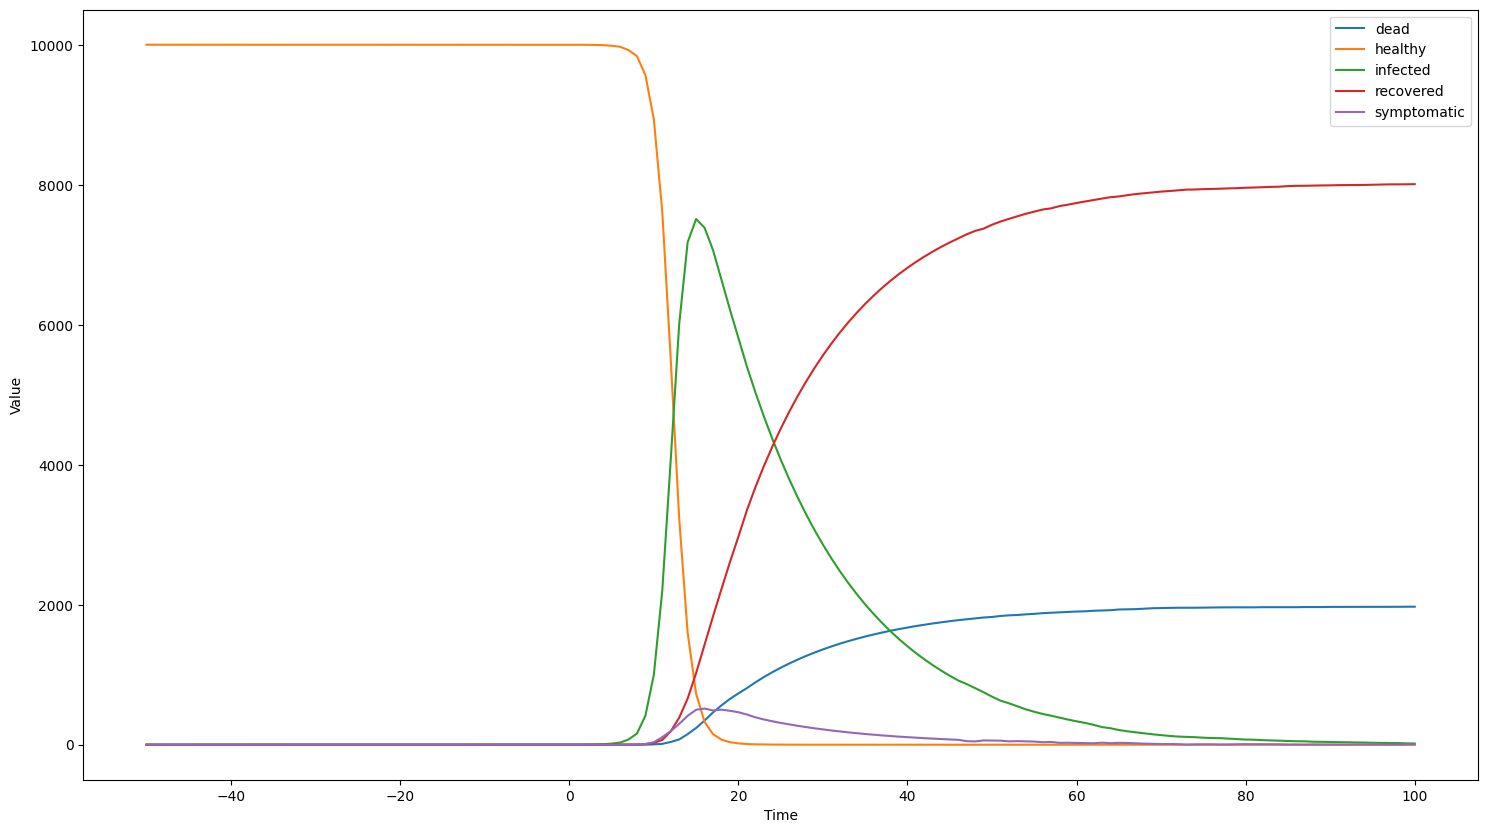

In [11]:
p_results.plot()